In [1]:
import glob
import os

from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd 
import scipy.stats as st
from sklearn.neighbors import KernelDensity
import sunpy.coordinates.sun as sn

import huxt as H
import huxt_analysis as HA
import sir_huxt_mono_obs as sir


mpl.rc("axes", labelsize=16)
mpl.rc("ytick", labelsize=16)
mpl.rc("xtick", labelsize=16)
mpl.rc("legend", fontsize=16)

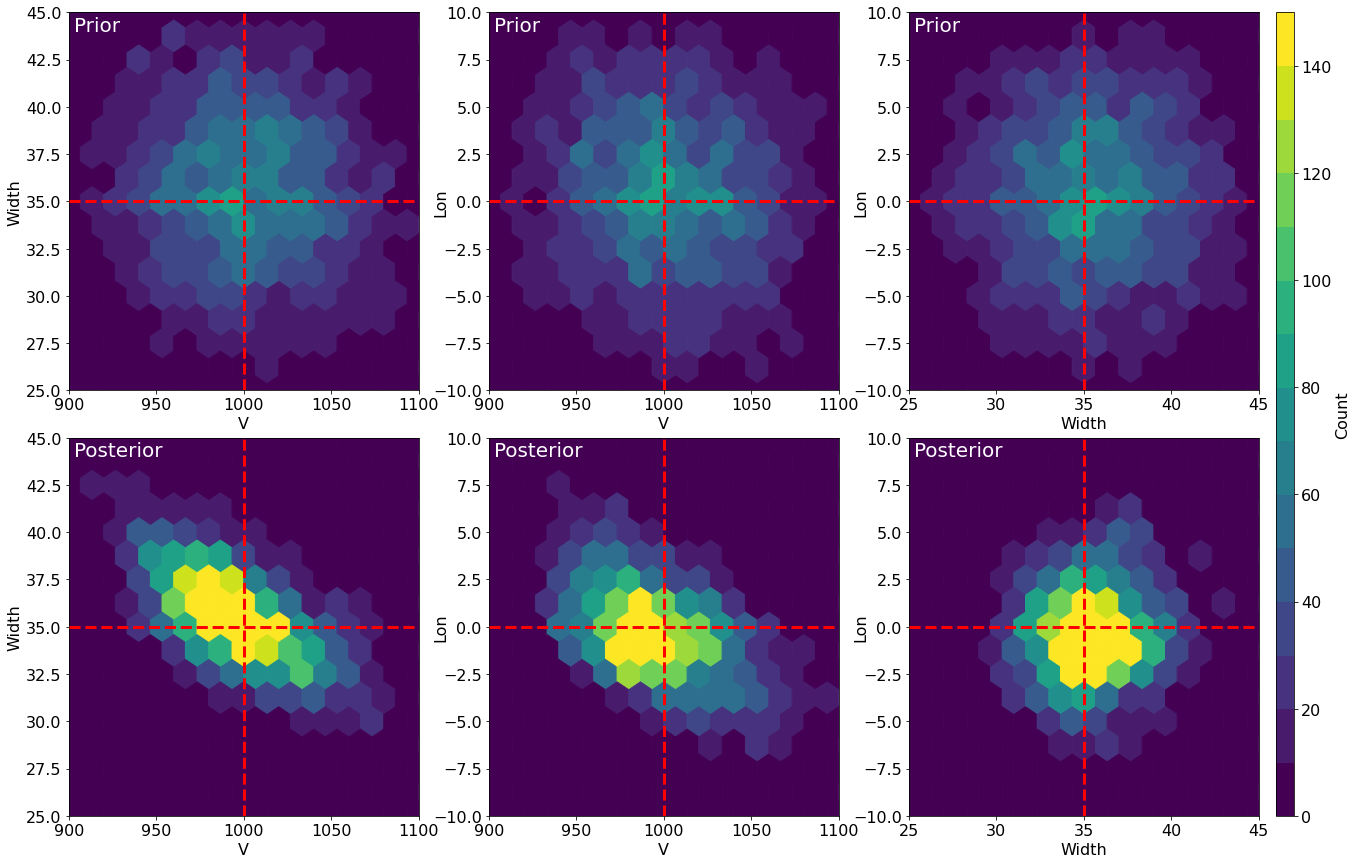

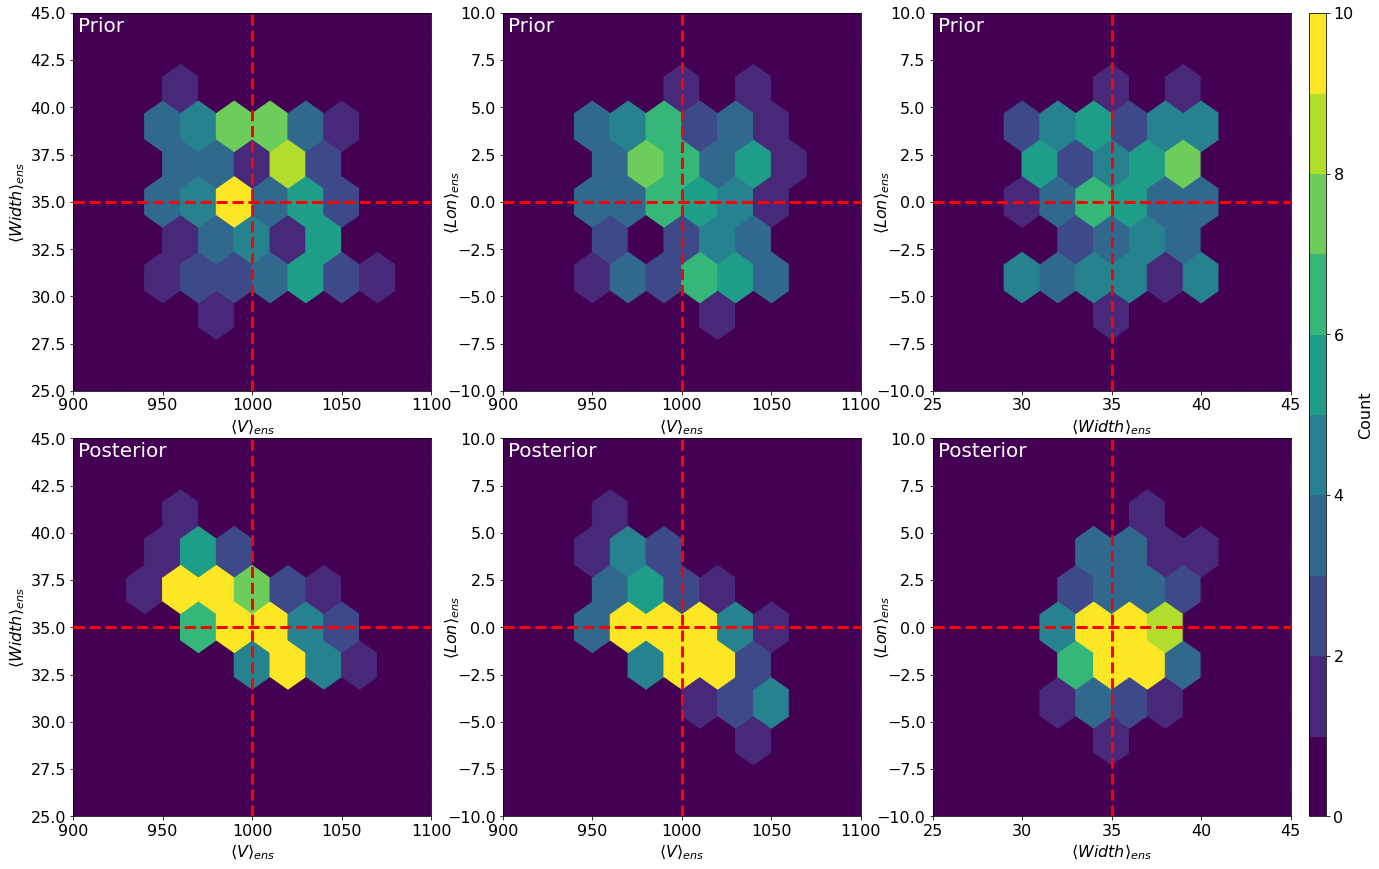

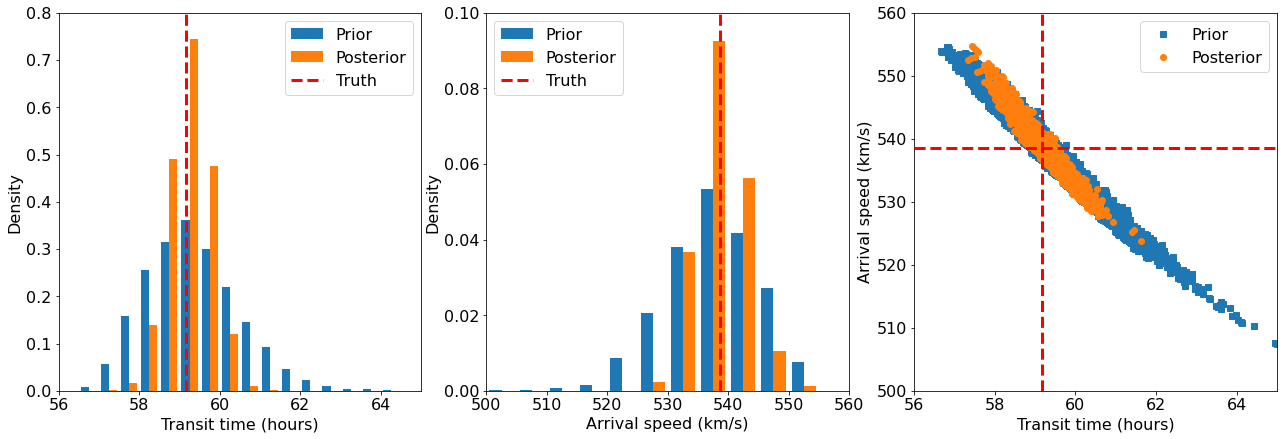

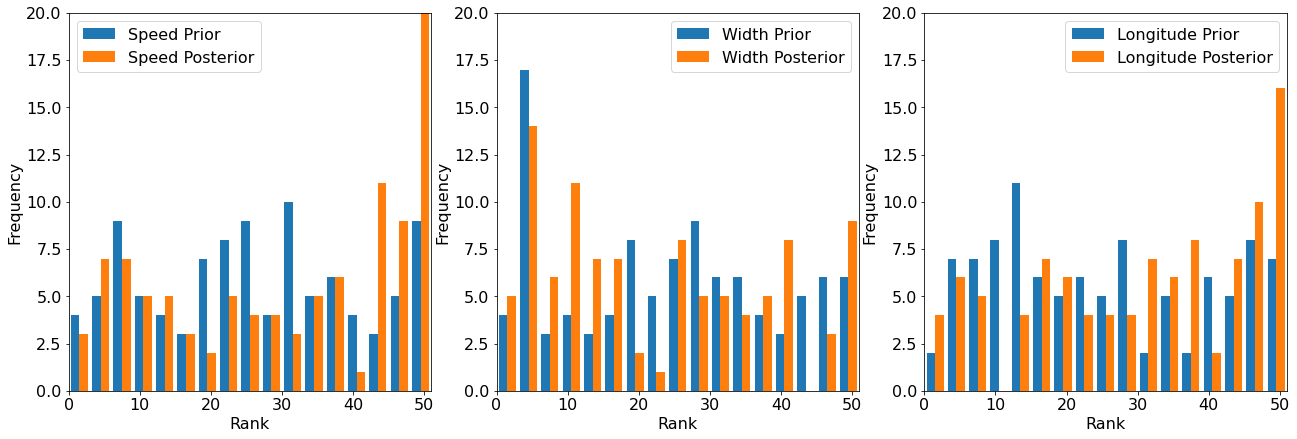

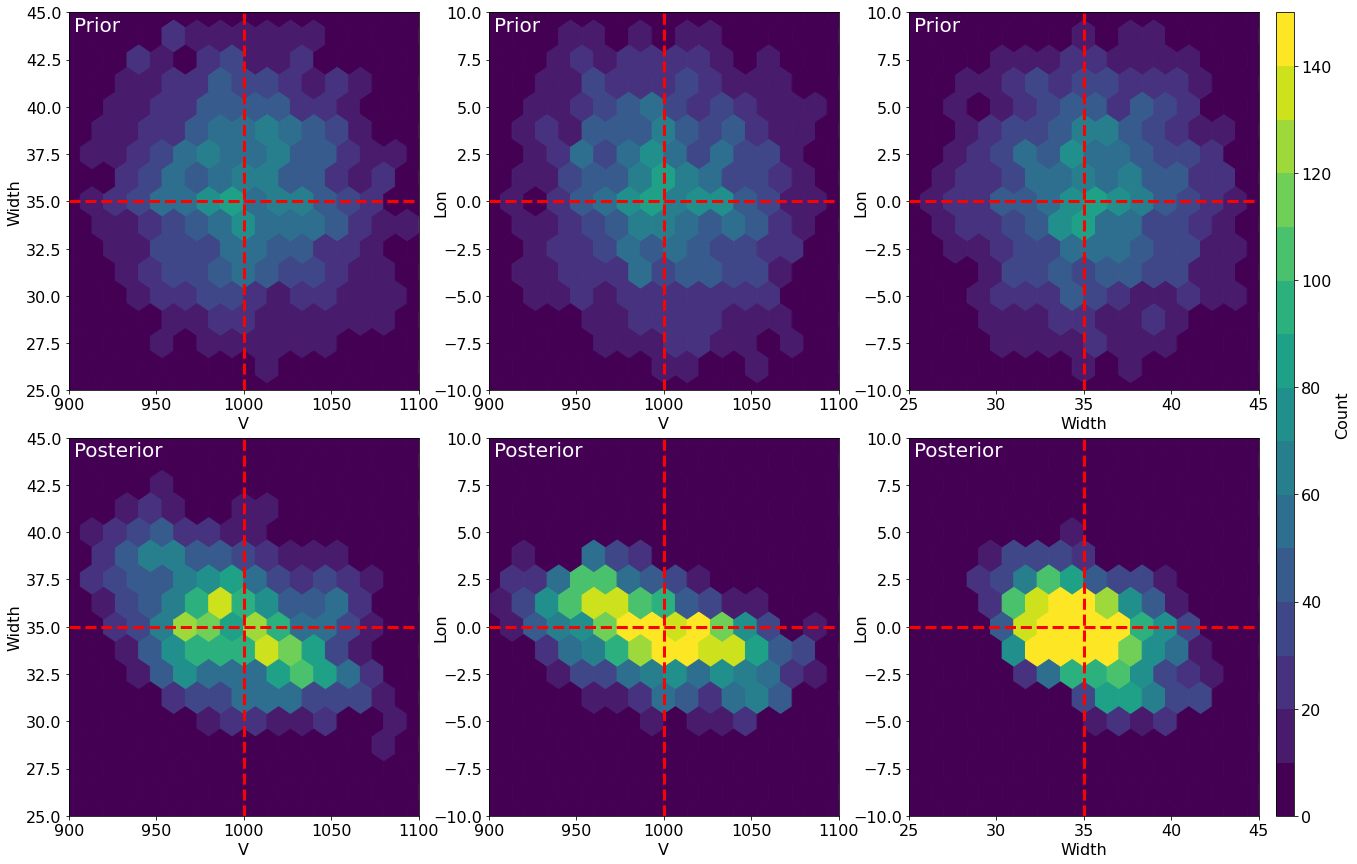

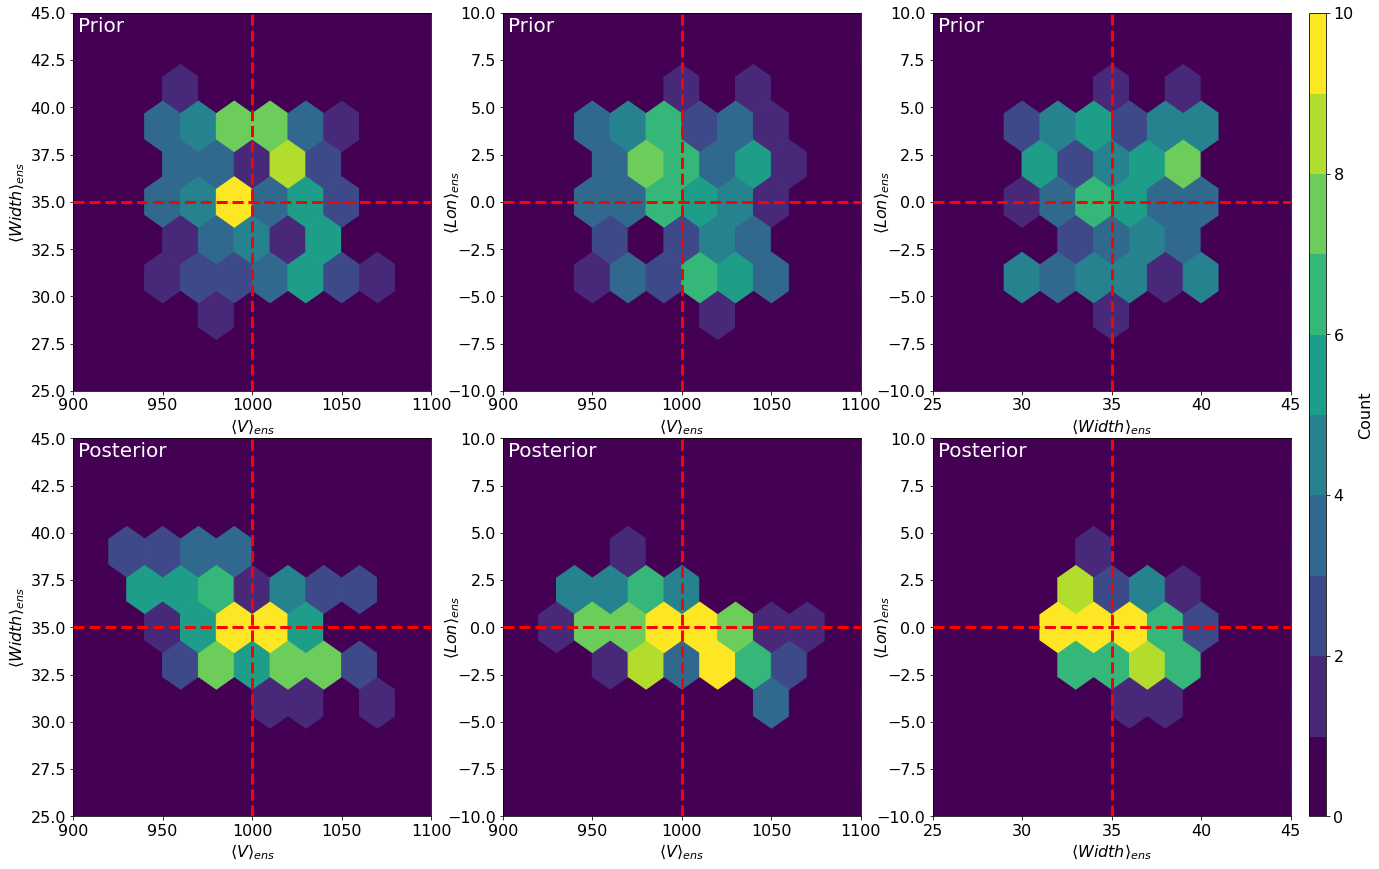

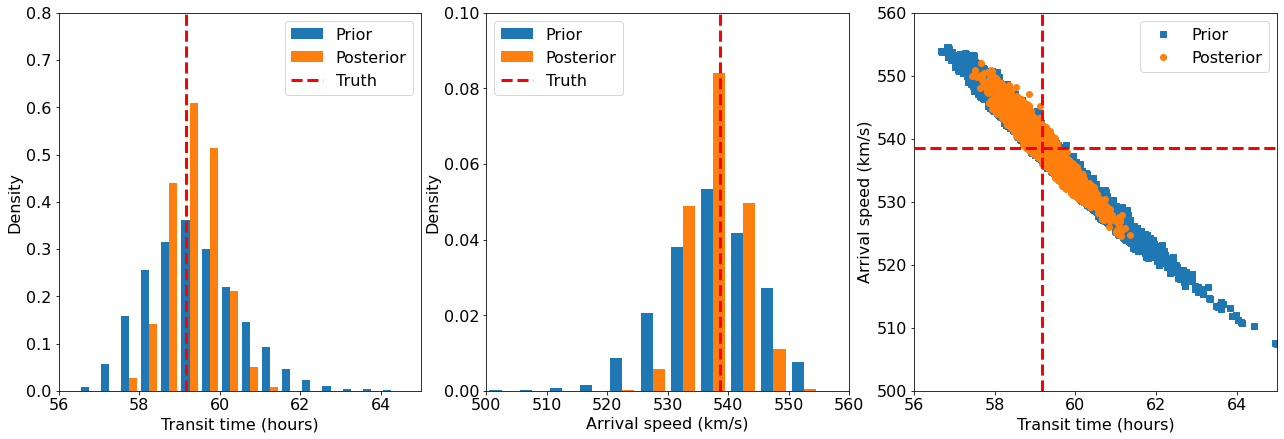

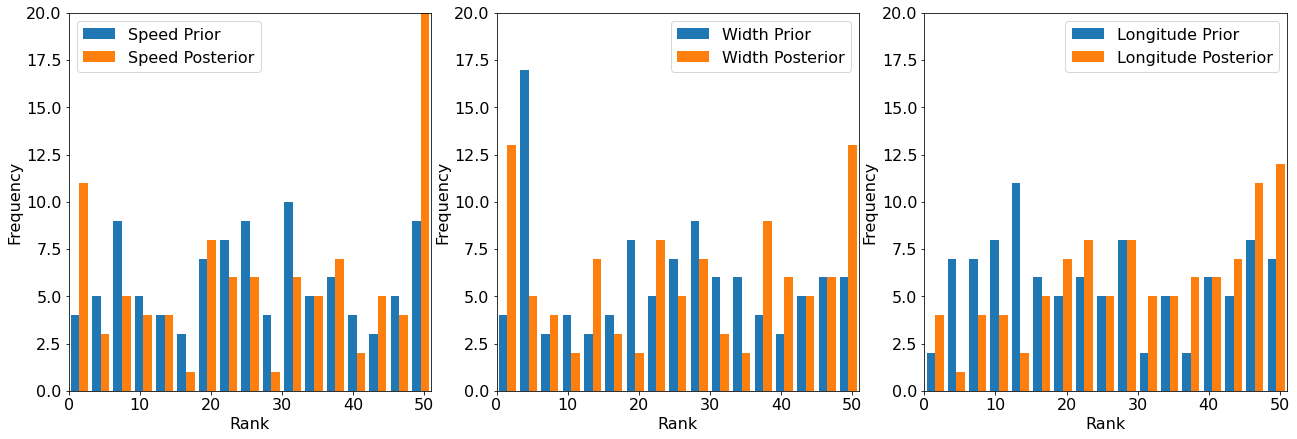

In [16]:
def summarise_osse_data(files):
    """
    Function to load and summarise the results from an SIR osse experiment. Takes a list of files returned by the osse, 
    and returns a dictionary summarising the ensemble and ensemble average of CME properties
    
    """
    # Get list of parameters to aggregate compute
    keys = ['v', 'v_avg', 'v_std', 'v_rank',
            'width', 'width_avg', 'width_std', 'width_rank',
            'lon', 'lon_avg', 'lon_std', 'lon_rank',
            't_transit', 't_transit_avg', 't_transit_std',
            'v_hit', 'v_hit_avg', 'v_hit_std']
    
    # Make dictionary to store aggregated ensemble data and computed statistics
    data = {'prior':{k:[] for k in keys}, 'post':{k:[] for k in keys},
            'truth':{'v':[], 'width':[], 'lon':[], 't_transit':[], 'v_hit':[]}}

    # Set a counter for files with no data for the prior or posterior steps
    bad_count = 0

    for i, f in enumerate(files):

        out_file = h5py.File(f, 'r')    

        # First file only, pull out the truth data. This is
        # identical across files
        if i == 0:
            # Parse out the true CME values
            cme_truth_params = out_file['truth_cme_params'][:]        
            data['truth']['v'] = cme_truth_params[4]
            data['truth']['width'] = np.rad2deg(cme_truth_params[3])
            lon_truth = np.rad2deg(cme_truth_params[1])
            if lon_truth > 180:
                lon_truth -= 360
            data['truth']['lon'] = lon_truth
            data['truth']['t_transit'] = out_file['t_transit'][()]
            data['truth']['v_hit'] = out_file['v_hit'][()]

        # Now pull out the ensemble data for the prior and posterior
        for j, key in enumerate(['prior', 'post']):
            
            if key == 'prior':
                analysis_key = 'analysis_00'
            elif key == 'post':
                analysis_key = 'analysis_07'

            if analysis_key not in out_file.keys():
                bad_count += 1
                continue
            
            for param in ['v', 'width', 'lon', 't_transit', 'v_hit']:
                # Now pass out the ensemble data
                x = out_file[analysis_key][param][:]
                if param == 'lon':
                    x[x>180] -= 360
                    data[key]['n_ens'] = len(x)
                    
                data[key][param].append(x)
                data[key][param + '_avg'].append(np.mean(x))
                data[key][param + '_std'].append(np.std(x))
                
                # Now compute rank of truth in each ensemble of CME core parameters
                if param in ['v', 'width', 'lon']:
                    x_truth = data['truth'][param]
                    x_all = np.append(x, x_truth)
                    x_ranks = st.rankdata(x_all)
                    data[key][param + '_rank'].append(x_ranks[-1])

        out_file.close()

    # Turn the lists to numpy arrays
    for key in ['prior', 'post']:
        for param, vals in data[key].items():
            data[key][param] = np.array(vals).ravel()
    
    return data


def plot_particle_distribution(data):
    """
    Make a hexbin plot of the particle density for each combination of CME paramters.
    """
    # Make hexbin plots of the particle densities
    fig, ax = plt.subplots(2, 3, figsize=(19, 12))

    vwlims = (900, 1100, 25, 45)
    vllims = (900, 1100, -10, 10)
    wllims = (25, 45, -10, 10)
    vmin = 0
    vmax = 150
        # define the bins and normalize
    cmap = mpl.cm.get_cmap('viridis')
    bounds = np.arange(vmin, vmax + 10, 10)
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

    for i, key in enumerate(['prior', 'post']):
        ax[i, 0].hexbin(data[key]['v'], data[key]['width'], gridsize=15, extent=vwlims, norm=norm, cmap=cmap)
        ax[i, 1].hexbin(data[key]['v'], data[key]['lon'], gridsize=15, extent=vllims, norm=norm, cmap=cmap)
        hb = ax[i, 2].hexbin(data[key]['width'], data[key]['lon'], gridsize=15, extent=wllims, norm=norm, cmap=cmap)

    
    # Format the axes
    for a in ax[:,0]:
        a.vlines(data['truth']['v'], vwlims[2], vwlims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['width'], vwlims[0], vwlims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(vwlims[0], vwlims[1])
        a.set_ylim(vwlims[2], vwlims[3]) 
        a.set_xlabel('V')
        a.set_ylabel('Width')

    for a in ax[:, 1]:
        a.vlines(data['truth']['v'], vllims[2], vllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['lon'], vllims[0], vllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(900, 1100)
        a.set_ylim(-10, 10)
        a.set_xlabel('V')
        a.set_ylabel('Lon')
        a.yaxis.labelpad = -15

    for a in ax[:, 2]:
        a.vlines(data['truth']['width'], wllims[2], wllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['lon'], wllims[0], wllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(25, 45)
        a.set_ylim(-10, 10)
        a.set_xlabel('Width')
        a.set_ylabel('Lon')
        a.yaxis.labelpad = -15

    labels = ['Prior', 'Posterior']
    for i, lab in enumerate(labels):
        for j in range(ax.shape[1]):
            ax[i, j].text(0.015, 0.95, lab, fontsize=20, color='w', transform=ax[i, j].transAxes)

    fig.subplots_adjust(left=0.06, bottom=0.06, right=0.93, top=0.99, wspace=0.2, hspace=0.125)

    pos1 = ax[0, 2].get_position()
    pos2 = ax[1, 2].get_position()
    dw = 0.005
    dh = 0.1
    top = pos1.y1
    bottom = pos2.y0
    height = top - bottom
    left = pos1.x1 + pos1.width/20
    wid = pos1.width/20
    cbaxes = fig.add_axes([left, bottom, wid, height])
    cbar = fig.colorbar(hb, cax=cbaxes, orientation='vertical')
    cbar.set_label('Count')
    
    return fig, ax

def plot_average_particle_distribution(data):
    """
    Make a hexbin plot of the particle density for each combination of CME paramters.
    """
    # Make hexbin plots of the particle densities
    fig, ax = plt.subplots(2, 3, figsize=(19, 12))

    vwlims = (900, 1100, 25, 45)
    vllims = (900, 1100, -10, 10)
    wllims = (25, 45, -10, 10)
    vmin = 0
    vmax = 10
    # define the bins and normalize
    cmap = mpl.cm.get_cmap('viridis')
    bounds = np.arange(vmin, vmax + 1, 1)
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

    for i, key in enumerate(['prior', 'post']):
        ax[i, 0].hexbin(data[key]['v_avg'], data[key]['width_avg'], gridsize=10, extent=vwlims, norm=norm, cmap=cmap)
        ax[i, 1].hexbin(data[key]['v_avg'], data[key]['lon_avg'], gridsize=10, extent=vllims, norm=norm, cmap=cmap)
        hb = ax[i, 2].hexbin(data[key]['width_avg'], data[key]['lon_avg'], gridsize=10, extent=wllims, norm=norm, cmap=cmap)

    # Format the axes
    for a in ax[:, 0]:
        a.vlines(data['truth']['v'], vwlims[2], vwlims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['width'], vwlims[0], vwlims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(vwlims[0], vwlims[1])
        a.set_ylim(vwlims[2], vwlims[3]) 
        a.set_xlabel('$\\langle V \\rangle_{{ens}}$')
        a.set_ylabel('$\\langle Width \\rangle_{{ens}}$')

    for a in ax[:, 1]:
        a.vlines(data['truth']['v'], vllims[2], vllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['lon'], vllims[0], vllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(900, 1100)
        a.set_ylim(-10, 10)
        a.set_xlabel('$\\langle V \\rangle_{{ens}}$')
        a.set_ylabel('$\\langle Lon \\rangle_{{ens}}$')
        a.yaxis.labelpad = -15

    for a in ax[:, 2]:
        a.vlines(data['truth']['width'],wllims[2], wllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(data['truth']['lon'], wllims[0], wllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(25, 45)
        a.set_ylim(-10, 10)
        a.set_xlabel('$\\langle Width \\rangle_{{ens}}$')
        a.set_ylabel('$\\langle Lon \\rangle_{{ens}}$')
        a.yaxis.labelpad = -15

    labels = ['Prior', 'Posterior']
    for i, lab in enumerate(labels):
        for j in range(ax.shape[1]):
            ax[i, j].text(0.015, 0.95, lab, fontsize=20, color='w', transform=ax[i, j].transAxes)

    fig.subplots_adjust(left=0.05, bottom=0.06, right=0.94, top=0.99, wspace=0.2, hspace=0.125)

    pos1 = ax[0, 2].get_position()
    pos2 = ax[1, 2].get_position()
    dw = 0.005
    dh = 0.1
    top = pos1.y1
    bottom = pos2.y0
    height = top - bottom
    left = pos1.x1 + pos1.width/20
    wid = pos1.width/20
    cbaxes = fig.add_axes([left, bottom, wid, height])
    cbar = fig.colorbar(hb, cax=cbaxes, orientation='vertical')
    cbar.set_label('Count')
    
    return fig, ax


def plot_arrival_distribution(data):
    """
    Make a hexbin plot of the particle density for each combination of CME paramters.
    """
    # Make hexbin plots of the particle densities
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Density estimates of arrival time
    t_arr_hists = [data[key]['t_transit']/3600 for key in ['prior', 'post']]
    v_hit_hists = [data[key]['v_hit'] for key in ['prior', 'post']]
    
    lims = (56, 65, 500, 560)
    
    labels = ['Prior', 'Posterior']
    ax[0].hist(t_arr_hists, np.arange(lims[0], lims[1], 0.5), density=True, label=labels)
    ax[0].vlines(data['truth']['t_transit']/3600, 0, 1.0, zorder=9, linestyle=['--'], colors='r', linewidth=3, label='Truth')
    
    ax[1].hist(v_hit_hists, np.arange(lims[2], lims[3], 5), density=True, label=labels)
    ax[1].vlines(data['truth']['v_hit'], 0, 1.0, zorder=9, linestyle=['--'], colors='r', linewidth=3, label='Truth')
    

    ax[2].plot(t_arr_hists[0], v_hit_hists[0],'s', color="C0", label=labels[0])
    ax[2].plot(t_arr_hists[1], v_hit_hists[1],'o', color="C1", label=labels[1])
    ax[2].hlines(data['truth']['v_hit'], lims[0], lims[1], zorder=9, linestyle=['--'], colors='r', linewidth=3)
    ax[2].vlines(data['truth']['t_transit']/3600, lims[2], lims[3], zorder=9, linestyle=['--'], colors='r', linewidth=3)
    
    ax[0].set_xlabel('Transit time (hours)')
    ax[0].set_ylabel('Density')
    
    ax[1].set_xlabel('Arrival speed (km/s)')
    ax[1].set_ylabel('Density')
    
    ax[2].set_xlabel('Transit time (hours)')
    ax[2].set_ylabel('Arrival speed (km/s)')
    
    ax[0].set_xlim(lims[0], lims[1])
    ax[0].set_ylim(0, 0.8)
    
    ax[1].set_xlim(lims[2], lims[3])
    ax[1].set_ylim(0, 0.1)
    
    ax[2].set_xlim(lims[0], lims[1])
    ax[2].set_ylim(lims[2], lims[3])
    
    for a in ax:
        a.legend()
        
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.975, wspace=0.18)
    
    return fig, ax

def plot_rank_histogram(data):
    n_ens = data['post']['n_ens']
    bins = np.arange(-3, n_ens + 3, 3)
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    for i, (param, label) in enumerate(zip(['v', 'width', 'lon'], ['Speed', 'Width', 'Longitude'])):

        ranks = [data['prior'][param + '_rank'], data['post'][param + '_rank']]

        ax[i].hist(ranks, bins=bins, label=[label+ ' Prior', label + ' Posterior'])

        ax[i].set_xlim(0,51)
        ax[i].set_ylim(0,20)
        ax[i].set_xlabel('Rank')
        ax[i].set_ylabel('Frequency')

        ax[i].legend()
        
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.975, wspace=0.18)
    
    return fig, ax

for lon in [300, 310]:
    dirs = sir.get_project_dirs()
    dir_tag = 'obs_lon_{}'.format(lon)
    data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
    files = glob.glob(data_dir)

    data = summarise_osse_data(files)
    fig, ax = plot_particle_distribution(data)
    name = 'fig1_particle_density_obs_lon_{}.png'.format(lon)
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path, facecolor='w')
    
    fig, ax = plot_average_particle_distribution(data)
    name = 'fig2_particle_density_average_obs_lon_{}.png'.format(lon)
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path, facecolor='w')
    
    fig, ax = plot_arrival_distribution(data)
    name = 'fig3_arrival_density_obs_lon_{}.png'.format(lon)
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path, facecolor='w')
    
    fig, ax = plot_rank_histogram(data)
    name = 'fig4_rank_hist_obs_lon_{}.png'.format(lon)
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path, facecolor='w')
    
